# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [01:27<00:00, 682File/s]  


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

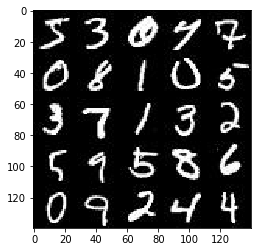

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

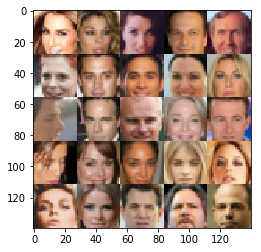

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/junhui.liaosap.com/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [40]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                               'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), 'input_z')
    learning_rate = tf.placeholder(tf.float32, None, 'learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input 28x28x3
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, filters=128, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha*x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(x1, filters=256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(x2, filters=512, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # 4x4x512
        
        flat = tf.reshape(x3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out_put = tf.sigmoid(logits)
        
    return out_put, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # input 28x28x3
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'same')
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [48]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    print_every = 10
    show_every = 100
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, 
                                                    lr: learning_rate})
                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f} ...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if step % show_every == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    
        show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.5130 ... Generator Loss: 7.2611
Epoch 1/2... Discriminator Loss: 1.7191 ... Generator Loss: 3.3141
Epoch 1/2... Discriminator Loss: 1.8750 ... Generator Loss: 2.5689
Epoch 1/2... Discriminator Loss: 1.9088 ... Generator Loss: 3.1987
Epoch 1/2... Discriminator Loss: 2.1588 ... Generator Loss: 1.8053
Epoch 1/2... Discriminator Loss: 2.4890 ... Generator Loss: 2.8826
Epoch 1/2... Discriminator Loss: 2.1033 ... Generator Loss: 2.1255
Epoch 1/2... Discriminator Loss: 1.8437 ... Generator Loss: 1.7568
Epoch 1/2... Discriminator Loss: 1.9465 ... Generator Loss: 1.9381
Epoch 1/2... Discriminator Loss: 1.7973 ... Generator Loss: 1.5872


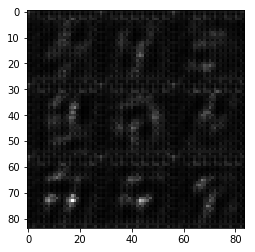

Epoch 1/2... Discriminator Loss: 1.8827 ... Generator Loss: 1.7728
Epoch 1/2... Discriminator Loss: 1.9368 ... Generator Loss: 1.8758
Epoch 1/2... Discriminator Loss: 1.8648 ... Generator Loss: 1.8979
Epoch 1/2... Discriminator Loss: 1.6314 ... Generator Loss: 1.5409
Epoch 1/2... Discriminator Loss: 1.7800 ... Generator Loss: 1.7650
Epoch 1/2... Discriminator Loss: 1.7859 ... Generator Loss: 1.6351
Epoch 1/2... Discriminator Loss: 1.6405 ... Generator Loss: 1.5030
Epoch 1/2... Discriminator Loss: 1.5928 ... Generator Loss: 1.4424
Epoch 1/2... Discriminator Loss: 1.3556 ... Generator Loss: 1.4250
Epoch 1/2... Discriminator Loss: 1.7179 ... Generator Loss: 1.6690


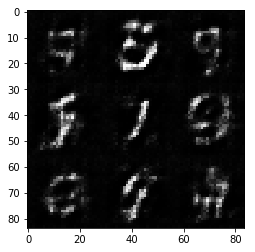

Epoch 1/2... Discriminator Loss: 1.5340 ... Generator Loss: 1.6762
Epoch 1/2... Discriminator Loss: 1.6076 ... Generator Loss: 1.5116
Epoch 1/2... Discriminator Loss: 1.3370 ... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 1.5630 ... Generator Loss: 1.7599
Epoch 1/2... Discriminator Loss: 1.7614 ... Generator Loss: 1.7813
Epoch 1/2... Discriminator Loss: 1.6067 ... Generator Loss: 1.6197
Epoch 1/2... Discriminator Loss: 1.6902 ... Generator Loss: 2.1548
Epoch 1/2... Discriminator Loss: 1.4566 ... Generator Loss: 0.9856
Epoch 1/2... Discriminator Loss: 1.6157 ... Generator Loss: 1.7810
Epoch 1/2... Discriminator Loss: 1.4777 ... Generator Loss: 1.3056


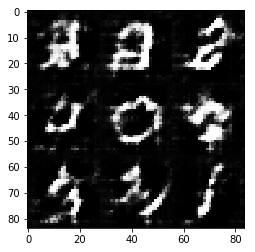

Epoch 1/2... Discriminator Loss: 1.3127 ... Generator Loss: 1.4039
Epoch 1/2... Discriminator Loss: 1.4956 ... Generator Loss: 1.5653
Epoch 1/2... Discriminator Loss: 1.5106 ... Generator Loss: 1.3696
Epoch 1/2... Discriminator Loss: 1.7055 ... Generator Loss: 1.3294
Epoch 1/2... Discriminator Loss: 1.4952 ... Generator Loss: 1.9482
Epoch 1/2... Discriminator Loss: 1.6143 ... Generator Loss: 1.4503
Epoch 1/2... Discriminator Loss: 2.0572 ... Generator Loss: 2.2968
Epoch 1/2... Discriminator Loss: 1.4750 ... Generator Loss: 1.6075
Epoch 1/2... Discriminator Loss: 1.7639 ... Generator Loss: 1.8681
Epoch 1/2... Discriminator Loss: 1.5710 ... Generator Loss: 1.2626


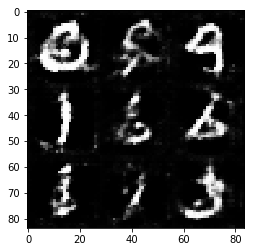

Epoch 1/2... Discriminator Loss: 1.5820 ... Generator Loss: 0.3901
Epoch 1/2... Discriminator Loss: 1.7463 ... Generator Loss: 0.3513
Epoch 1/2... Discriminator Loss: 1.2899 ... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 1.4254 ... Generator Loss: 1.4703
Epoch 1/2... Discriminator Loss: 1.5141 ... Generator Loss: 1.3303
Epoch 1/2... Discriminator Loss: 1.4814 ... Generator Loss: 1.5297
Epoch 2/2... Discriminator Loss: 1.5376 ... Generator Loss: 1.4155
Epoch 2/2... Discriminator Loss: 1.3495 ... Generator Loss: 1.0879
Epoch 2/2... Discriminator Loss: 1.4887 ... Generator Loss: 1.3094
Epoch 2/2... Discriminator Loss: 1.5393 ... Generator Loss: 1.3777


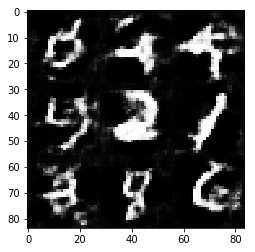

Epoch 2/2... Discriminator Loss: 1.6089 ... Generator Loss: 1.9133
Epoch 2/2... Discriminator Loss: 1.4464 ... Generator Loss: 1.2272
Epoch 2/2... Discriminator Loss: 1.4869 ... Generator Loss: 1.5304
Epoch 2/2... Discriminator Loss: 1.3007 ... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 1.4194 ... Generator Loss: 1.6390
Epoch 2/2... Discriminator Loss: 1.6263 ... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 1.7425 ... Generator Loss: 0.3145
Epoch 2/2... Discriminator Loss: 1.5153 ... Generator Loss: 1.4194
Epoch 2/2... Discriminator Loss: 1.7845 ... Generator Loss: 1.7457
Epoch 2/2... Discriminator Loss: 1.6082 ... Generator Loss: 0.3966


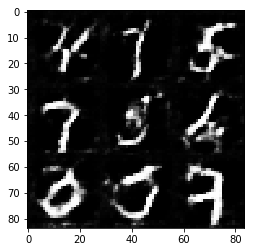

Epoch 2/2... Discriminator Loss: 1.4173 ... Generator Loss: 0.4758
Epoch 2/2... Discriminator Loss: 1.6268 ... Generator Loss: 0.4150
Epoch 2/2... Discriminator Loss: 1.5220 ... Generator Loss: 0.5950
Epoch 2/2... Discriminator Loss: 1.7301 ... Generator Loss: 0.3420
Epoch 2/2... Discriminator Loss: 1.6129 ... Generator Loss: 0.4288
Epoch 2/2... Discriminator Loss: 1.7712 ... Generator Loss: 0.3283
Epoch 2/2... Discriminator Loss: 1.3641 ... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 1.5808 ... Generator Loss: 1.3383
Epoch 2/2... Discriminator Loss: 1.4001 ... Generator Loss: 1.3870
Epoch 2/2... Discriminator Loss: 1.7811 ... Generator Loss: 0.3566


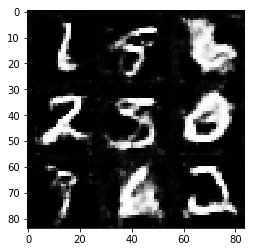

Epoch 2/2... Discriminator Loss: 1.7047 ... Generator Loss: 0.3412
Epoch 2/2... Discriminator Loss: 1.4099 ... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.5639 ... Generator Loss: 1.6671
Epoch 2/2... Discriminator Loss: 1.5237 ... Generator Loss: 1.6432
Epoch 2/2... Discriminator Loss: 1.3472 ... Generator Loss: 1.4412
Epoch 2/2... Discriminator Loss: 1.7198 ... Generator Loss: 1.5714
Epoch 2/2... Discriminator Loss: 1.3877 ... Generator Loss: 1.7315
Epoch 2/2... Discriminator Loss: 1.3463 ... Generator Loss: 1.2010
Epoch 2/2... Discriminator Loss: 1.2912 ... Generator Loss: 1.2205
Epoch 2/2... Discriminator Loss: 1.5048 ... Generator Loss: 0.8595


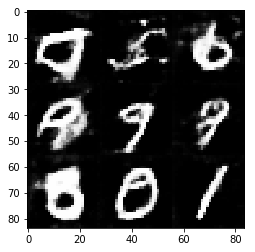

Epoch 2/2... Discriminator Loss: 1.8502 ... Generator Loss: 2.1360
Epoch 2/2... Discriminator Loss: 1.3921 ... Generator Loss: 1.1839
Epoch 2/2... Discriminator Loss: 1.2790 ... Generator Loss: 1.0845
Epoch 2/2... Discriminator Loss: 1.3922 ... Generator Loss: 1.5055
Epoch 2/2... Discriminator Loss: 1.2683 ... Generator Loss: 1.2697
Epoch 2/2... Discriminator Loss: 1.5271 ... Generator Loss: 0.4571
Epoch 2/2... Discriminator Loss: 1.3940 ... Generator Loss: 0.7431
Epoch 2/2... Discriminator Loss: 1.4648 ... Generator Loss: 1.7582
Epoch 2/2... Discriminator Loss: 1.5140 ... Generator Loss: 1.7012
Epoch 2/2... Discriminator Loss: 1.5080 ... Generator Loss: 1.1521


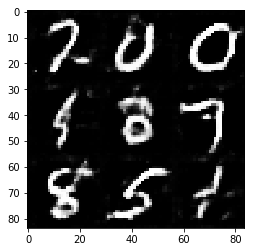

Epoch 2/2... Discriminator Loss: 1.4742 ... Generator Loss: 0.6546
Epoch 2/2... Discriminator Loss: 1.4488 ... Generator Loss: 1.2949
Epoch 2/2... Discriminator Loss: 1.3821 ... Generator Loss: 1.3548


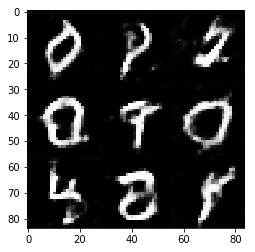

In [49]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.1913 ... Generator Loss: 1.8806
Epoch 1/1... Discriminator Loss: 2.8740 ... Generator Loss: 13.8230
Epoch 1/1... Discriminator Loss: 4.9398 ... Generator Loss: 2.9934
Epoch 1/1... Discriminator Loss: 4.2089 ... Generator Loss: 1.9083
Epoch 1/1... Discriminator Loss: 0.6187 ... Generator Loss: 5.5488
Epoch 1/1... Discriminator Loss: 3.3187 ... Generator Loss: 2.8011
Epoch 1/1... Discriminator Loss: 1.5296 ... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.4023 ... Generator Loss: 2.0472
Epoch 1/1... Discriminator Loss: 4.6016 ... Generator Loss: 3.9489
Epoch 1/1... Discriminator Loss: 4.4731 ... Generator Loss: 5.9023


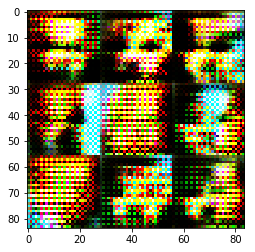

Epoch 1/1... Discriminator Loss: 0.7360 ... Generator Loss: 1.8556
Epoch 1/1... Discriminator Loss: 2.7404 ... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 2.1595 ... Generator Loss: 2.3475
Epoch 1/1... Discriminator Loss: 1.9358 ... Generator Loss: 3.0817
Epoch 1/1... Discriminator Loss: 1.7882 ... Generator Loss: 4.2654
Epoch 1/1... Discriminator Loss: 2.2238 ... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 0.7927 ... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 0.9738 ... Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 0.5479 ... Generator Loss: 2.9260
Epoch 1/1... Discriminator Loss: 3.4913 ... Generator Loss: 2.9891


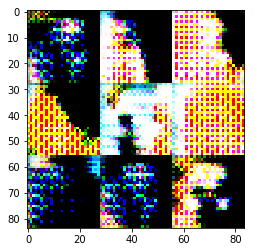

Epoch 1/1... Discriminator Loss: 1.0530 ... Generator Loss: 2.1476
Epoch 1/1... Discriminator Loss: 0.9767 ... Generator Loss: 2.4744
Epoch 1/1... Discriminator Loss: 0.9468 ... Generator Loss: 3.1683
Epoch 1/1... Discriminator Loss: 0.8985 ... Generator Loss: 3.2336
Epoch 1/1... Discriminator Loss: 0.4755 ... Generator Loss: 2.2399
Epoch 1/1... Discriminator Loss: 3.4890 ... Generator Loss: 5.6585
Epoch 1/1... Discriminator Loss: 0.4812 ... Generator Loss: 2.4721
Epoch 1/1... Discriminator Loss: 0.8095 ... Generator Loss: 1.9298
Epoch 1/1... Discriminator Loss: 0.5208 ... Generator Loss: 2.9999
Epoch 1/1... Discriminator Loss: 0.4095 ... Generator Loss: 3.0274


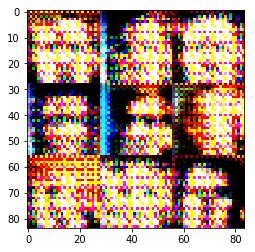

Epoch 1/1... Discriminator Loss: 0.3617 ... Generator Loss: 3.9452
Epoch 1/1... Discriminator Loss: 0.3564 ... Generator Loss: 4.1772
Epoch 1/1... Discriminator Loss: 0.3801 ... Generator Loss: 4.7996
Epoch 1/1... Discriminator Loss: 0.3421 ... Generator Loss: 4.6602
Epoch 1/1... Discriminator Loss: 0.3428 ... Generator Loss: 4.6717
Epoch 1/1... Discriminator Loss: 0.3376 ... Generator Loss: 5.1115
Epoch 1/1... Discriminator Loss: 0.3474 ... Generator Loss: 4.2769
Epoch 1/1... Discriminator Loss: 0.3462 ... Generator Loss: 5.0047
Epoch 1/1... Discriminator Loss: 0.3417 ... Generator Loss: 4.8900
Epoch 1/1... Discriminator Loss: 0.3332 ... Generator Loss: 5.7540


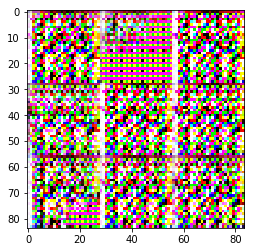

Epoch 1/1... Discriminator Loss: 0.3340 ... Generator Loss: 6.0483
Epoch 1/1... Discriminator Loss: 0.3410 ... Generator Loss: 4.9401
Epoch 1/1... Discriminator Loss: 0.3313 ... Generator Loss: 5.6376
Epoch 1/1... Discriminator Loss: 0.3403 ... Generator Loss: 4.8319
Epoch 1/1... Discriminator Loss: 0.3289 ... Generator Loss: 6.4110
Epoch 1/1... Discriminator Loss: 0.3470 ... Generator Loss: 10.0092
Epoch 1/1... Discriminator Loss: 7.1139 ... Generator Loss: 0.0024
Epoch 1/1... Discriminator Loss: 5.0897 ... Generator Loss: 5.3966
Epoch 1/1... Discriminator Loss: 0.6431 ... Generator Loss: 1.7119
Epoch 1/1... Discriminator Loss: 1.1155 ... Generator Loss: 0.7987


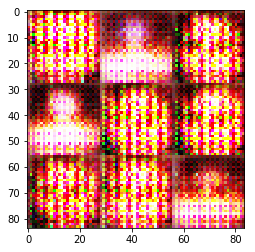

Epoch 1/1... Discriminator Loss: 1.4529 ... Generator Loss: 3.2926
Epoch 1/1... Discriminator Loss: 1.8016 ... Generator Loss: 2.9689
Epoch 1/1... Discriminator Loss: 0.6809 ... Generator Loss: 3.0197
Epoch 1/1... Discriminator Loss: 1.2927 ... Generator Loss: 3.6853
Epoch 1/1... Discriminator Loss: 1.1222 ... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 0.4939 ... Generator Loss: 2.9799
Epoch 1/1... Discriminator Loss: 0.6580 ... Generator Loss: 1.9328
Epoch 1/1... Discriminator Loss: 4.6242 ... Generator Loss: 0.1768
Epoch 1/1... Discriminator Loss: 1.6404 ... Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 1.1304 ... Generator Loss: 3.0933


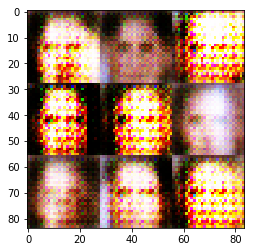

Epoch 1/1... Discriminator Loss: 1.8993 ... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 0.9791 ... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 0.4312 ... Generator Loss: 4.1308
Epoch 1/1... Discriminator Loss: 0.4046 ... Generator Loss: 2.8643
Epoch 1/1... Discriminator Loss: 0.3462 ... Generator Loss: 5.6908
Epoch 1/1... Discriminator Loss: 0.4137 ... Generator Loss: 2.8558
Epoch 1/1... Discriminator Loss: 0.4053 ... Generator Loss: 3.2711
Epoch 1/1... Discriminator Loss: 0.3463 ... Generator Loss: 6.6532
Epoch 1/1... Discriminator Loss: 0.3379 ... Generator Loss: 5.3264
Epoch 1/1... Discriminator Loss: 0.8959 ... Generator Loss: 2.4586


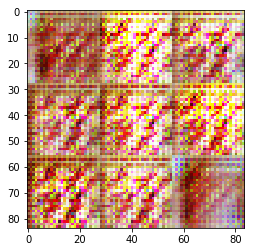

Epoch 1/1... Discriminator Loss: 0.4318 ... Generator Loss: 2.8582
Epoch 1/1... Discriminator Loss: 0.8298 ... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 2.1984 ... Generator Loss: 0.2293
Epoch 1/1... Discriminator Loss: 1.0199 ... Generator Loss: 1.4723
Epoch 1/1... Discriminator Loss: 0.7961 ... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 1.3841 ... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 0.3845 ... Generator Loss: 3.7711
Epoch 1/1... Discriminator Loss: 1.4218 ... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 0.5094 ... Generator Loss: 1.9035
Epoch 1/1... Discriminator Loss: 0.5903 ... Generator Loss: 2.1090


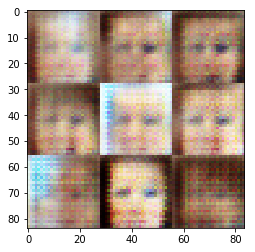

Epoch 1/1... Discriminator Loss: 1.1795 ... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 0.6162 ... Generator Loss: 1.6147
Epoch 1/1... Discriminator Loss: 0.4193 ... Generator Loss: 2.7806
Epoch 1/1... Discriminator Loss: 1.1277 ... Generator Loss: 1.2993
Epoch 1/1... Discriminator Loss: 1.2590 ... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 0.3606 ... Generator Loss: 4.8435
Epoch 1/1... Discriminator Loss: 0.3919 ... Generator Loss: 3.1253
Epoch 1/1... Discriminator Loss: 1.9870 ... Generator Loss: 4.8679
Epoch 1/1... Discriminator Loss: 1.1296 ... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.1536 ... Generator Loss: 1.2480


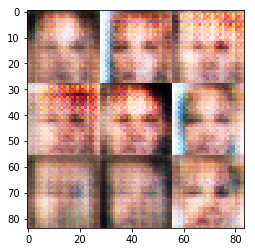

Epoch 1/1... Discriminator Loss: 1.1241 ... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.2380 ... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.1980 ... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.1804 ... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.1086 ... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 0.4932 ... Generator Loss: 2.0393
Epoch 1/1... Discriminator Loss: 1.4646 ... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.3484 ... Generator Loss: 2.1210
Epoch 1/1... Discriminator Loss: 1.0153 ... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.4108 ... Generator Loss: 1.7168


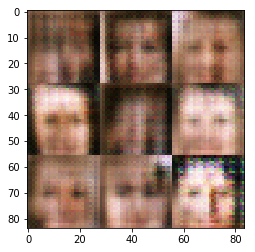

Epoch 1/1... Discriminator Loss: 1.1495 ... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 0.5130 ... Generator Loss: 1.9697
Epoch 1/1... Discriminator Loss: 1.3077 ... Generator Loss: 2.0251
Epoch 1/1... Discriminator Loss: 1.2105 ... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 0.3930 ... Generator Loss: 3.3288
Epoch 1/1... Discriminator Loss: 0.3704 ... Generator Loss: 3.7152
Epoch 1/1... Discriminator Loss: 0.3681 ... Generator Loss: 3.9077
Epoch 1/1... Discriminator Loss: 0.3652 ... Generator Loss: 3.9425
Epoch 1/1... Discriminator Loss: 0.3626 ... Generator Loss: 3.8572
Epoch 1/1... Discriminator Loss: 0.3435 ... Generator Loss: 5.4410


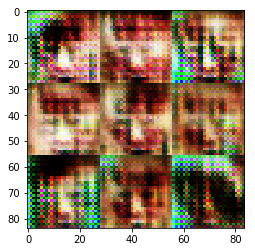

Epoch 1/1... Discriminator Loss: 0.3921 ... Generator Loss: 3.7034
Epoch 1/1... Discriminator Loss: 0.3418 ... Generator Loss: 5.1168
Epoch 1/1... Discriminator Loss: 0.4170 ... Generator Loss: 2.7982
Epoch 1/1... Discriminator Loss: 0.8211 ... Generator Loss: 1.7273
Epoch 1/1... Discriminator Loss: 0.4786 ... Generator Loss: 2.6532
Epoch 1/1... Discriminator Loss: 0.3381 ... Generator Loss: 7.6108
Epoch 1/1... Discriminator Loss: 7.7872 ... Generator Loss: 8.8110
Epoch 1/1... Discriminator Loss: 1.0729 ... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.1565 ... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.1375 ... Generator Loss: 0.9646


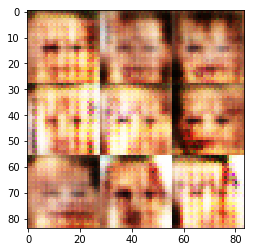

Epoch 1/1... Discriminator Loss: 1.0280 ... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 1.1507 ... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3282 ... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.7141 ... Generator Loss: 2.1382
Epoch 1/1... Discriminator Loss: 1.5778 ... Generator Loss: 1.9129
Epoch 1/1... Discriminator Loss: 1.2341 ... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 0.8713 ... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 1.2525 ... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.1247 ... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3203 ... Generator Loss: 0.5994


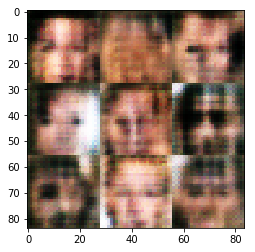

Epoch 1/1... Discriminator Loss: 1.5600 ... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 1.1934 ... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.1447 ... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 1.1575 ... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.1703 ... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.0932 ... Generator Loss: 1.5037
Epoch 1/1... Discriminator Loss: 1.4587 ... Generator Loss: 1.6877
Epoch 1/1... Discriminator Loss: 1.2146 ... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 1.1175 ... Generator Loss: 1.2010
Epoch 1/1... Discriminator Loss: 1.2016 ... Generator Loss: 1.4232


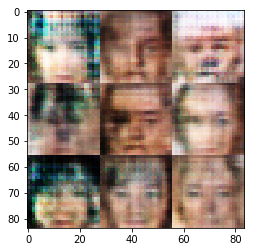

Epoch 1/1... Discriminator Loss: 1.1803 ... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 1.2100 ... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.1546 ... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 1.3318 ... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 1.1242 ... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3485 ... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3032 ... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4860 ... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.2817 ... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.2212 ... Generator Loss: 0.7874


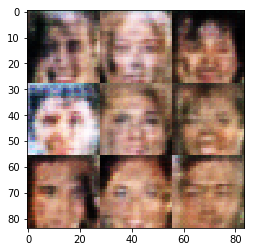

Epoch 1/1... Discriminator Loss: 0.8595 ... Generator Loss: 1.9031
Epoch 1/1... Discriminator Loss: 0.4504 ... Generator Loss: 2.5132
Epoch 1/1... Discriminator Loss: 0.5474 ... Generator Loss: 3.9960
Epoch 1/1... Discriminator Loss: 0.8379 ... Generator Loss: 1.6729
Epoch 1/1... Discriminator Loss: 2.8539 ... Generator Loss: 4.5609
Epoch 1/1... Discriminator Loss: 0.9561 ... Generator Loss: 1.8034
Epoch 1/1... Discriminator Loss: 0.8973 ... Generator Loss: 1.6080
Epoch 1/1... Discriminator Loss: 1.2883 ... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.2811 ... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.2920 ... Generator Loss: 1.2498


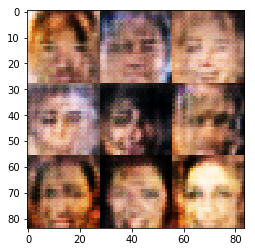

Epoch 1/1... Discriminator Loss: 1.2786 ... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.1047 ... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.3323 ... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 0.6734 ... Generator Loss: 1.3548
Epoch 1/1... Discriminator Loss: 0.4115 ... Generator Loss: 2.6532
Epoch 1/1... Discriminator Loss: 1.5091 ... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 1.2766 ... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.2812 ... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.2740 ... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.3090 ... Generator Loss: 0.5956


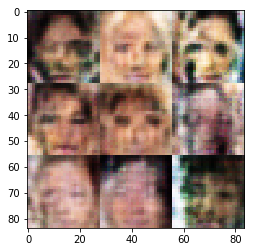

Epoch 1/1... Discriminator Loss: 1.1143 ... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.2387 ... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.3741 ... Generator Loss: 1.5226
Epoch 1/1... Discriminator Loss: 1.1203 ... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.1831 ... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.2169 ... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 0.4780 ... Generator Loss: 2.6990
Epoch 1/1... Discriminator Loss: 0.6109 ... Generator Loss: 1.7247
Epoch 1/1... Discriminator Loss: 1.3583 ... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.3281 ... Generator Loss: 0.9147


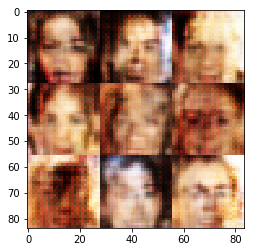

Epoch 1/1... Discriminator Loss: 1.4357 ... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 1.3746 ... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.3354 ... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.2827 ... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.2928 ... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.3015 ... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3527 ... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 0.7607 ... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 0.4901 ... Generator Loss: 1.9882
Epoch 1/1... Discriminator Loss: 0.3839 ... Generator Loss: 3.4456


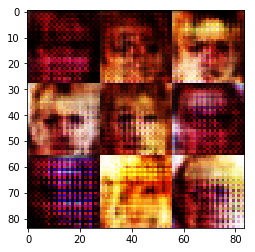

Epoch 1/1... Discriminator Loss: 0.5030 ... Generator Loss: 3.5904
Epoch 1/1... Discriminator Loss: 0.3387 ... Generator Loss: 5.0768
Epoch 1/1... Discriminator Loss: 0.3554 ... Generator Loss: 5.9866
Epoch 1/1... Discriminator Loss: 0.3545 ... Generator Loss: 3.9120
Epoch 1/1... Discriminator Loss: 0.3429 ... Generator Loss: 4.4430
Epoch 1/1... Discriminator Loss: 0.3491 ... Generator Loss: 4.1549
Epoch 1/1... Discriminator Loss: 0.3391 ... Generator Loss: 5.4046
Epoch 1/1... Discriminator Loss: 0.3818 ... Generator Loss: 4.3465
Epoch 1/1... Discriminator Loss: 0.3278 ... Generator Loss: 9.5461
Epoch 1/1... Discriminator Loss: 0.3301 ... Generator Loss: 6.9368


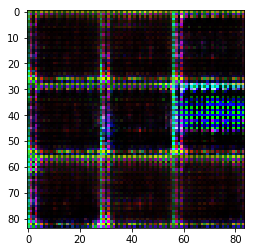

Epoch 1/1... Discriminator Loss: 0.3288 ... Generator Loss: 6.4547
Epoch 1/1... Discriminator Loss: 0.3301 ... Generator Loss: 6.3925
Epoch 1/1... Discriminator Loss: 0.3306 ... Generator Loss: 7.5713
Epoch 1/1... Discriminator Loss: 0.3310 ... Generator Loss: 5.9129
Epoch 1/1... Discriminator Loss: 0.3340 ... Generator Loss: 5.0376
Epoch 1/1... Discriminator Loss: 0.3331 ... Generator Loss: 5.3530
Epoch 1/1... Discriminator Loss: 0.3362 ... Generator Loss: 4.7528
Epoch 1/1... Discriminator Loss: 0.3375 ... Generator Loss: 7.3734
Epoch 1/1... Discriminator Loss: 0.3290 ... Generator Loss: 8.2890
Epoch 1/1... Discriminator Loss: 0.3294 ... Generator Loss: 6.2669


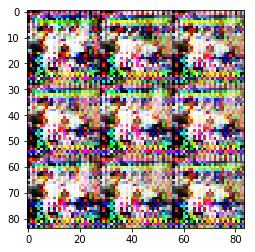

Epoch 1/1... Discriminator Loss: 0.3280 ... Generator Loss: 7.4807
Epoch 1/1... Discriminator Loss: 0.3292 ... Generator Loss: 7.7703
Epoch 1/1... Discriminator Loss: 0.3303 ... Generator Loss: 6.1025
Epoch 1/1... Discriminator Loss: 0.3312 ... Generator Loss: 10.0945
Epoch 1/1... Discriminator Loss: 0.3267 ... Generator Loss: 7.9008
Epoch 1/1... Discriminator Loss: 0.3288 ... Generator Loss: 6.6785
Epoch 1/1... Discriminator Loss: 0.3282 ... Generator Loss: 6.4781
Epoch 1/1... Discriminator Loss: 0.3292 ... Generator Loss: 14.0782
Epoch 1/1... Discriminator Loss: 0.3263 ... Generator Loss: 8.5583
Epoch 1/1... Discriminator Loss: 0.3263 ... Generator Loss: 9.2070


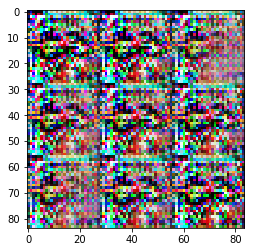

Epoch 1/1... Discriminator Loss: 0.3279 ... Generator Loss: 10.1128
Epoch 1/1... Discriminator Loss: 0.3284 ... Generator Loss: 10.2861
Epoch 1/1... Discriminator Loss: 0.3268 ... Generator Loss: 8.1526
Epoch 1/1... Discriminator Loss: 0.3264 ... Generator Loss: 9.4215
Epoch 1/1... Discriminator Loss: 0.3278 ... Generator Loss: 7.1376
Epoch 1/1... Discriminator Loss: 0.3336 ... Generator Loss: 4.9773
Epoch 1/1... Discriminator Loss: 0.3269 ... Generator Loss: 7.9986
Epoch 1/1... Discriminator Loss: 0.3300 ... Generator Loss: 5.5812
Epoch 1/1... Discriminator Loss: 0.3362 ... Generator Loss: 11.1765
Epoch 1/1... Discriminator Loss: 0.3273 ... Generator Loss: 7.1738


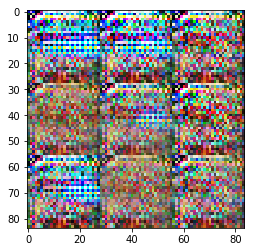

Epoch 1/1... Discriminator Loss: 0.3259 ... Generator Loss: 11.7289
Epoch 1/1... Discriminator Loss: 0.3273 ... Generator Loss: 6.4642
Epoch 1/1... Discriminator Loss: 0.3329 ... Generator Loss: 5.4545
Epoch 1/1... Discriminator Loss: 0.3259 ... Generator Loss: 8.9981
Epoch 1/1... Discriminator Loss: 0.3297 ... Generator Loss: 5.6406
Epoch 1/1... Discriminator Loss: 0.3265 ... Generator Loss: 12.0120
Epoch 1/1... Discriminator Loss: 0.3271 ... Generator Loss: 8.1158
Epoch 1/1... Discriminator Loss: 0.3258 ... Generator Loss: 8.5174
Epoch 1/1... Discriminator Loss: 0.3290 ... Generator Loss: 8.4271
Epoch 1/1... Discriminator Loss: 0.3572 ... Generator Loss: 3.5903


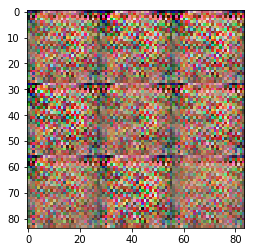

Epoch 1/1... Discriminator Loss: 0.3267 ... Generator Loss: 10.9513
Epoch 1/1... Discriminator Loss: 0.3267 ... Generator Loss: 7.7430
Epoch 1/1... Discriminator Loss: 0.3294 ... Generator Loss: 7.3344
Epoch 1/1... Discriminator Loss: 0.3301 ... Generator Loss: 6.0862
Epoch 1/1... Discriminator Loss: 0.3262 ... Generator Loss: 13.5978
Epoch 1/1... Discriminator Loss: 1.5988 ... Generator Loss: 5.7524
Epoch 1/1... Discriminator Loss: 0.4353 ... Generator Loss: 3.0076
Epoch 1/1... Discriminator Loss: 0.3841 ... Generator Loss: 3.3875
Epoch 1/1... Discriminator Loss: 1.0657 ... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.5653 ... Generator Loss: 0.6185


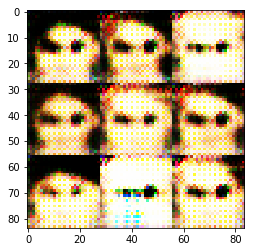

Epoch 1/1... Discriminator Loss: 1.1789 ... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 0.9796 ... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.1570 ... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.5211 ... Generator Loss: 2.4647
Epoch 1/1... Discriminator Loss: 2.2252 ... Generator Loss: 0.1969
Epoch 1/1... Discriminator Loss: 1.1660 ... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.0253 ... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.3720 ... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.1367 ... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.1534 ... Generator Loss: 2.7371


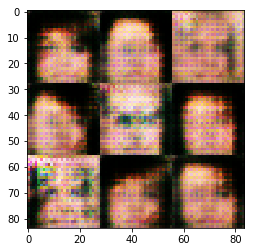

Epoch 1/1... Discriminator Loss: 1.2156 ... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.7171 ... Generator Loss: 0.3360
Epoch 1/1... Discriminator Loss: 0.9593 ... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.3374 ... Generator Loss: 2.1039
Epoch 1/1... Discriminator Loss: 1.2885 ... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.2693 ... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 1.0118 ... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.5350 ... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.7259 ... Generator Loss: 2.3129
Epoch 1/1... Discriminator Loss: 1.0082 ... Generator Loss: 1.0364


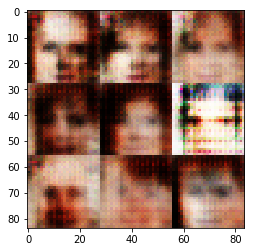

Epoch 1/1... Discriminator Loss: 0.8766 ... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 2.1355 ... Generator Loss: 2.7971
Epoch 1/1... Discriminator Loss: 0.9440 ... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.8694 ... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 1.0745 ... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 0.9890 ... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.3543 ... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.0401 ... Generator Loss: 3.2093
Epoch 1/1... Discriminator Loss: 1.7106 ... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 1.2567 ... Generator Loss: 0.9341


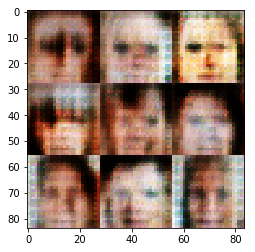

Epoch 1/1... Discriminator Loss: 2.2441 ... Generator Loss: 2.4123
Epoch 1/1... Discriminator Loss: 1.1488 ... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.0361 ... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.8322 ... Generator Loss: 0.3016
Epoch 1/1... Discriminator Loss: 0.7173 ... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 1.2815 ... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.1641 ... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.2279 ... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.6262 ... Generator Loss: 2.0340
Epoch 1/1... Discriminator Loss: 1.2300 ... Generator Loss: 0.9231


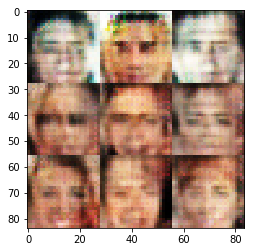

Epoch 1/1... Discriminator Loss: 1.2496 ... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.2975 ... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 1.2118 ... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.9150 ... Generator Loss: 2.1357
Epoch 1/1... Discriminator Loss: 1.4112 ... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.3268 ... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.1512 ... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.2104 ... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.2382 ... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.1489 ... Generator Loss: 1.2385


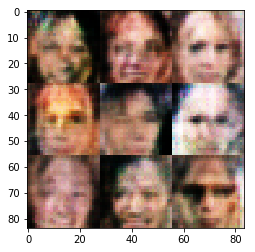

Epoch 1/1... Discriminator Loss: 1.2434 ... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 1.2275 ... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 1.2723 ... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.3395 ... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.3142 ... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.2795 ... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3381 ... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3434 ... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.3009 ... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3101 ... Generator Loss: 0.6647


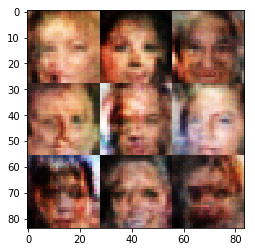

Epoch 1/1... Discriminator Loss: 1.2068 ... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.1303 ... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.2093 ... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.2662 ... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.6849 ... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.3108 ... Generator Loss: 0.8651


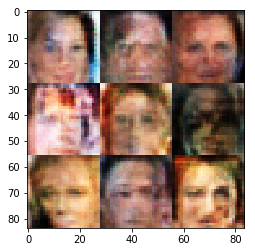

In [50]:
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.